In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
epochs = 100
batch_size = 48
testsplit = .5
targetx = 100
targety = 100
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
print(seed)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/raf-db-dataset/DATASET/train/"
data_dir1 = "/kaggle/input/raf-db-dataset/DATASET/test/"

940


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       
)
val_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"
        
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 12271 images belonging to 7 classes.
Found 1535 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


/kaggle/input/raf-db-dataset/DATASET/train/4/train_03526_aligned.jpg


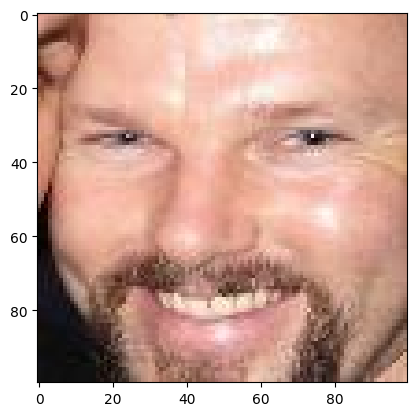

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('DenseNet121.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=.5,
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [6]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization

In [7]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image("model.png")

In [8]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Learning rate:  0.001
Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 2.2753 - accuracy: 0.5583End of epoch 0. Learning rate: 0.001

Epoch 1: val_accuracy improved from -inf to 0.22215, saving model to DenseNet121.h5
256/256 [==============================] - 201s 461ms/step - loss: 2.2753 - accuracy: 0.5583 - val_loss: 2.6947 - val_accuracy: 0.2221 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
256/256 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.6933End of epoch 1. Learning rate: 0.001

Epoch 2: val_accuracy improved from 0.22215 to 0.44691, saving model to DenseNet121.h5
256/256 [==============================] - 42s 162ms/step - loss: 1.6045 - accuracy: 0.6933 - val_loss: 2.2978 - val_accuracy: 0.4469 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
256/256 [==============================] - ETA: 0s - loss: 1.2880 - accuracy: 0.7369End of epoch 2. Learning rate: 0.001

Epoch 3: val_accuracy improved from 0.44691 to 

In [9]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet121.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,2.275317,0.558308,2.694658,0.222150,0.001000
1,1.604515,0.693261,2.297757,0.446906,0.001000
2,1.287992,0.736859,2.039291,0.555700,0.001000
3,1.104645,0.758944,1.412986,0.644300,0.001000
4,0.956663,0.776791,1.037714,0.741368,0.001000
5,0.873668,0.789341,1.179992,0.671010,0.001000
6,0.826714,0.795942,1.289060,0.652769,0.001000
7,0.746372,0.817700,0.926914,0.741368,0.001000
8,0.705581,0.822508,1.067577,0.731596,0.001000
9,0.680664,0.829680,0.887098,0.756352,0.001000


<h2>Plotting<h2>

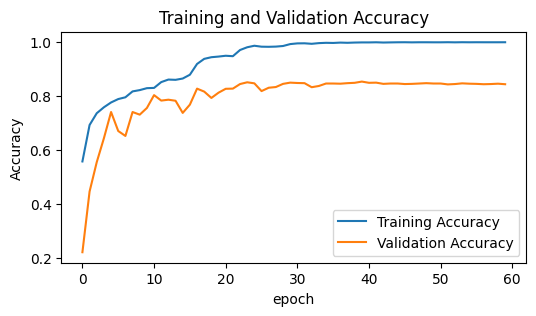

In [10]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

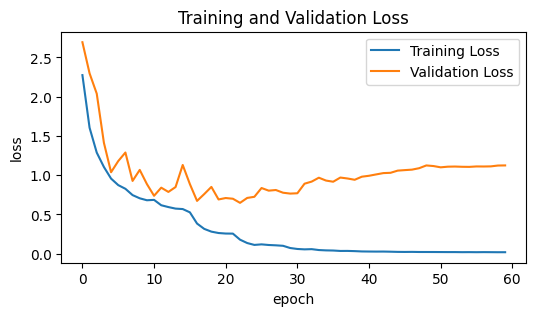

In [11]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [12]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

           1       0.85      0.79      0.82       164
           2       0.52      0.46      0.49        37
           3       0.67      0.62      0.65        80
           4       0.95      0.95      0.95       592
           5       0.80      0.87      0.83       239
           6       0.74      0.74      0.74        81
           7       0.85      0.86      0.85       340

    accuracy                           0.86      1533
   macro avg       0.77      0.76      0.76      1533
weighted avg       0.86      0.86      0.86      1533



In [13]:
#confusion matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[129,   9,   4,   5,   3,   4,  10],
       [  5,  17,   2,   1,   6,   1,   5],
       [  1,   1,  50,   4,   7,   8,   9],
       [  3,   1,   2, 561,   9,   6,  10],
       [  1,   2,   6,   7, 208,   2,  13],
       [  1,   3,   6,   2,   4,  60,   5],
       [ 11,   0,   5,   9,  23,   0, 292]])

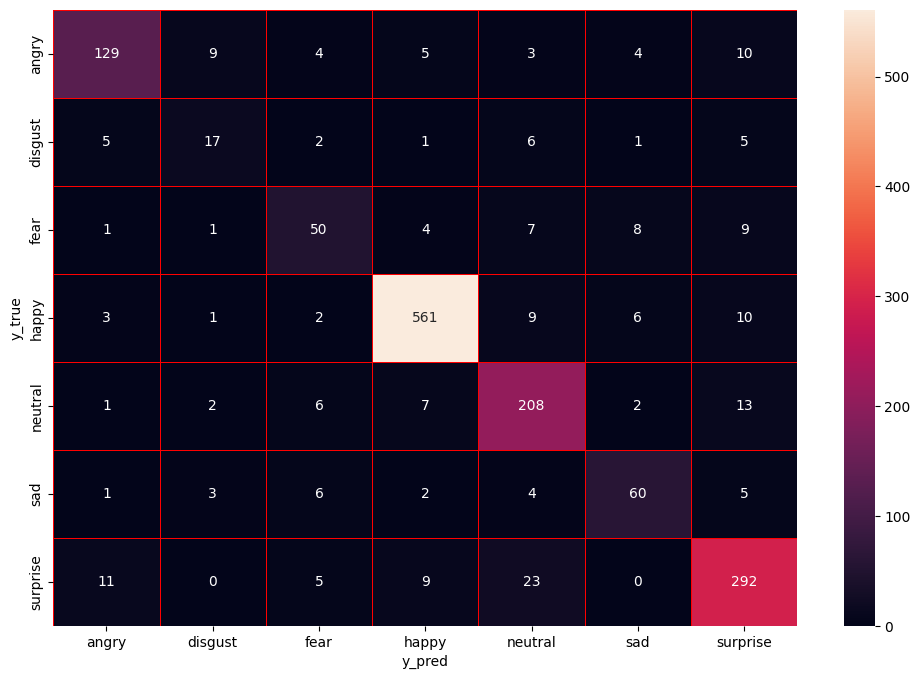

In [14]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix.png', transparent=False, dpi=500)
plt.show()

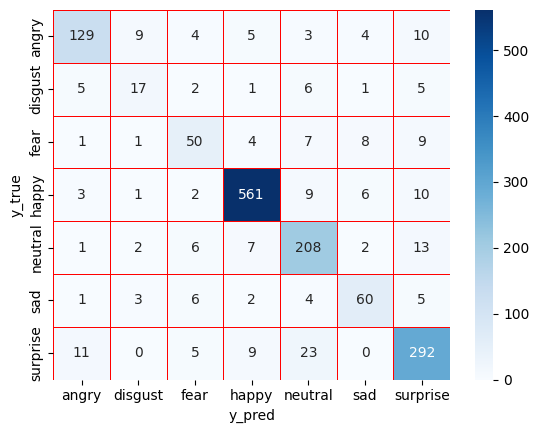

In [15]:
sns.heatmap(cm,cmap="Blues",annot=True,linewidths=0.5,linecolor="red",fmt=".0f",xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix2.png', transparent=False, dpi=500)
plt.show()

In [16]:
model.evaluate(test_generator , verbose = 1)

32/32 [==============================] - 3s 100ms/step - loss: 0.9907 - accuracy: 0.8591


[0.9906567335128784, 0.859099805355072]

1/1 [==============================] - 3s 3s/step
4


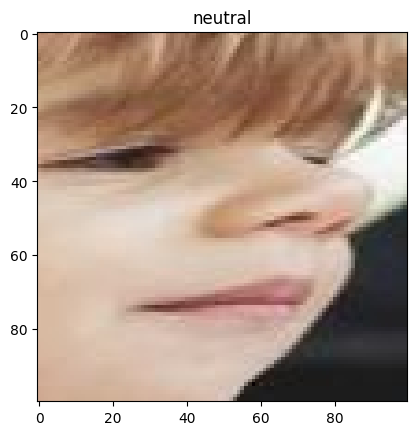

In [17]:
#Test the model
model = load_model('/kaggle/working/DenseNet121.h5')

test_image='/kaggle/input/raf-db-dataset/DATASET/test/4/test_0003_aligned.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(targetx, targety))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)
print(np.argmax(result))
Categories =target_names
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()